In this project we are looking at the titanic dataset. I am also implement decision trees by hand and then using bagging and random forests to optimize the prediction

In [432]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt  
import random
from sklearn.model_selection import train_test_split
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Trees and Forests

In [433]:
titanic = pd.read_csv("./titanic.csv.bz2")
gender = pd.get_dummies(titanic['sex'])
embark_location = pd.get_dummies(titanic['embarked'])
home = pd.get_dummies(titanic['home.dest'])[['New York, NY','London' ,'Montreal, PQ']]
titanic_dmy = pd.concat([titanic,gender,embark_location,home],axis=1)
titanic_dmy.drop(['body'],axis=1,inplace=True)
titanic_dmy.groupby('survived').mean().T

survived,0,1
pclass,2.500618,1.962000
age,30.545369,28.918228
sibsp,0.521632,0.462000
parch,0.328801,0.476000
fare,23.353831,49.361184
female,0.156984,0.678000
male,0.843016,0.322000
C,0.148331,0.300000
Q,0.097651,0.088000
S,0.754017,0.608000


In [434]:
titanic_dmy_summary = titanic_dmy.drop(['name', 'home.dest','cabin', 'boat', 'embarked', 'sex', 'ticket'],axis=1)
summary = pd.DataFrame(index=titanic_dmy_summary.columns)
summary['Mean'] = titanic_dmy_summary.mean()
summary['STD'] = titanic_dmy_summary.std()
summary['NumMissing'] = titanic_dmy_summary.isnull().sum()
summary.index.name = "Variables"
l = []
listofname = titanic_dmy_summary.columns
for x in listofname:
    l.append(np.corrcoef(titanic_dmy_summary[x], titanic_dmy_summary['survived'])[0,1])
summary["Correlation"] = l
print(summary)


                   Mean        STD  NumMissing  Correlation
Variables                                                  
pclass         2.294882   0.837836           0    -0.312469
survived       0.381971   0.486055           0     1.000000
age           29.881135  14.413500         263          NaN
sibsp          0.498854   1.041658           0    -0.027825
parch          0.385027   0.865560           0     0.082660
fare          33.295479  51.758668           1          NaN
female         0.355997   0.478997           0     0.528693
male           0.644003   0.478997           0    -0.528693
C              0.206264   0.404777           0     0.182123
Q              0.093965   0.291891           0    -0.016071
S              0.698243   0.459196           0    -0.154558
New York, NY   0.048892   0.215725           0     0.113408
London         0.010695   0.102902           0    -0.005313
Montreal, PQ   0.007639   0.087103           0     0.003256


# Implement decision tree

## Create binary variables

In [435]:
titanic_dmy_binary = titanic_dmy_summary.drop(['female', 'fare' ],axis=1)
classDummies = pd.get_dummies(titanic_dmy_summary['pclass'])
classDummies.columns = ['pc1', 'pc2', 'pc3']
ageGroup = pd.cut(titanic_dmy_binary['age'],[0,10, 18, 45,60,200], right=False)
ageGroup
ageDummies = pd.get_dummies(ageGroup)
titanicData = pd.concat([titanic_dmy_binary,classDummies,ageDummies],axis=1)
titanicData.drop(['age','parch','sibsp','pclass'], axis=1, inplace=True)

In [436]:
 X_train, X_test, y_train, y_test = train_test_split( titanicData, titanicData['survived'], test_size=.2)

## Implement the decision tree with binary variables

In [437]:
def growTree(data):
    if data.shape[1] < 5:
        return [data['survived'].sum() / len(data)]
    elif data.shape[0] < 3:
        return [data['survived'].sum() / len(data)]
    else:
        survived = data['survived'].sum() / len(data)
        dead = (data['survived'] == 0).sum() / len(data)
        entropy = -1 * survived * math.log(survived, 2) - dead * math.log(dead,2)
        print(entropy)
        minEntropy = entropy
        minIndex = -1
        for i in range(1, data.shape[1]):
            df1 = data[data[data.columns[i]] == 1]
            df0 = data[data[data.columns[i]] == 0]
            if not (len(df0) == 0 or len(df1) == 0):
                survivedIf1 = df1['survived'].sum() / len(df1)
                survivedIf0 = df0['survived'].sum() / len(df0)
                deadIf1 = (df1['survived'] == 0).sum() / len(df1)
                deadIf0 = (df0['survived'] == 0).sum() / len(df0)
                if survivedIf0 == 0.0:
                    return [data.columns[i], [0.0], growTree(data.drop([data.columns[i]], axis=1))]
                if survivedIf1 == 0.0:
                    return [data.columns[i], growTree(data.drop([data.columns[i]], axis=1)), [0.0] ]
                if survivedIf0 == 1.0:
                    return [data.columns[i], [1.0], growTree(data.drop([data.columns[i]], axis=1))]
                if survivedIf1 == 1.0:
                    return [data.columns[i], growTree(data.drop([data.columns[i]], axis=1)), [1.0] ]

                yEntropy = -1 * survivedIf1 * math.log(survivedIf1, 2) - deadIf1 * math.log(deadIf1,2)
                nEntropy = -1 * survivedIf0 * math.log(survivedIf0, 2) - deadIf0 * math.log(deadIf0,2)

                weightedAvg = (yEntropy * len(df1) + nEntropy * len(df0)) / (len(df1) + len(df0))
                if weightedAvg < minEntropy:
                    minEntropy = weightedAvg
                    minIndex = i
        dataSplit1 = data[data[data.columns[minIndex]] == 1].drop([data.columns[minIndex]], axis=1)
        dataSplit0 = data[data[data.columns[minIndex]] == 0].drop([data.columns[minIndex]], axis=1)
        if len(dataSplit0) == 0:
            return [dataSplit1['survived'].sum() / len(dataSplit1)]
        if len(dataSplit1) == 0:
            return [dataSplit0['survived'].sum() / len(dataSplit0)]
        
        return [data.columns[minIndex], growTree(dataSplit0), growTree(dataSplit1)]
tree = growTree(X_train)

print("first three levels of tree:")
print("\t\t\t\t",tree[0])
print("\t\t",tree[1][0], "\t\t", tree[2][0])
print("\t", tree[1][1][0], "\t\t", tree[1][2][0],"\t\t",tree[2][1][0],"\t", tree[2][2][0])
print(tree[1][1][1][0], "\t", tree[1][1][2][0], "\t\t\t", tree[2][1][1][0],"\t",tree[2][1][2][0] )

predictions = np.empty(X_test.shape[0])
for i in range(X_test.shape[0]):
    predictionTree = tree.copy();
    while(len(predictionTree) > 2):
        path = X_test.iloc[i][predictionTree[0]]
        predictionTree = predictionTree[path + 1]
    if predictionTree[0] > .5: 
        predictions[i] = 1
    else:
        predictions[i] = 0
        
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("Accuracy:", (tp+tn) / (tp+fp+fn+tn))
print("Precision:", tp/(tp + fp))
print("Recall:", tp/(tp+fn))

first three levels of tree:
				 male
		 Montreal, PQ 		 Montreal, PQ
	 pc3 		 1.0 		 pc1 	 0.0
Q 	 [60, 200) 			 New York, NY 	 Q
Accuracy: 0.828244274809
Precision: 0.893333333333
Recall: 0.644230769231


# Bagging and Random Forests

## Bagging

In [438]:
B = 5
trees = {}
for i in range(B):
    selectedData = X_train.sample(n=len(X_train), replace=True)
    trees[i] = growTree(selectedData)
predictions = np.empty(X_test.shape[0])
allAgree = 0;
for i in range(X_test.shape[0]):
    innerPredictions = np.empty(B)
    for j in range(B):
        predictionTree = trees[list(trees.keys())[j]].copy();
        while(len(predictionTree) > 2):
            path = X_test.iloc[i][predictionTree[0]]
            predictionTree = predictionTree[path + 1]
        if predictionTree[0] > .5: 
            innerPredictions[j] = 1
        else:
            innerPredictions[j] = 0
    if(innerPredictions.sum() > (B/2)):
        predictions[i] = 1
    else:
        predictions[i] = 0
    if(innerPredictions.sum() == 0 or innerPredictions.sum() == B):
        allAgree += 1
    
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("All trees agree:", allAgree, "times on", X_test.shape[0], "predictions")
print("Accuracy:", (tp+tn) / (tp+fp+fn+tn))
print("Precision:", tp/(tp + fp))
print("Recall:", tp/(tp+fn))  

All trees agree: 229 times on 262 predictions
Accuracy: 0.839694656489
Precision: 0.897435897436
Recall: 0.673076923077


In [439]:
accuracy = np.empty(10)
precision = np.empty(10)
recall = np.empty(10)
J = 0
for H in range(5,300,60):
    B = H
    trees = {}
    for i in range(B):
        selectedData = X_train.sample(n=len(X_train), replace=True)
        trees[i] = growTree(selectedData)
    predictions = np.empty(X_test.shape[0])
    allAgree = 0;
    for i in range(X_test.shape[0]):
        innerPredictions = np.empty(B)
        for j in range(B):
            predictionTree = trees[list(trees.keys())[j]].copy();
            while(len(predictionTree) > 2):
                path = X_test.iloc[i][predictionTree[0]]
                predictionTree = predictionTree[path + 1]
            if predictionTree[0] > .5: 
                innerPredictions[j] = 1
            else:
                innerPredictions[j] = 0
        if(innerPredictions.sum() > (B/2)):
            predictions[i] = 1
        else:
            predictions[i] = 0
        if(innerPredictions.sum() == 0 or innerPredictions.sum() == B):
            allAgree += 1

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    accuracy[J] = (tp+tn) / (tp+fp+fn+tn)
    precision[J] = tp/(tp + fp)
    recall[J] = tp/(tp+fn)
    J = J + 1

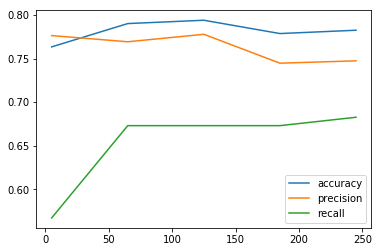

In [442]:
plt.plot(range(5,300,60), accuracy[:5])
plt.plot(range(5,300,60), precision[:5])
plt.plot(range(5,300,60), recall[:5])
plt.legend(['accuracy','precision','recall'])
plt.show()

Anything higher than around 100 looks to be an optimal bag size

## Random Forests

In [443]:
accuracy = np.empty(10)
precision = np.empty(10)
recall = np.empty(10)
J=0
for H in range(5,1001,100):
    B = H
    trees = {}
    for i in range(B):
        selectedData = X_train.sample(n=int(len(X_train)**(1/2.0)), replace=True)
        trees[i] = growTree(selectedData)
    predictions = np.empty(X_test.shape[0])
    for i in range(X_test.shape[0]):
        innerPredictions = np.empty(B)
        for j in range(B):
            predictionTree = trees[list(trees.keys())[j]].copy();
            while(len(predictionTree) > 2):
                path = X_test.iloc[i][predictionTree[0]]
                predictionTree = predictionTree[path + 1]
            if predictionTree[0] > .5: 
                innerPredictions[j] = 1
            else:
                innerPredictions[j] = 0
        if(innerPredictions.sum() > (B/2)):
            predictions[i] = 1
        else:
            predictions[i] = 0

    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    accuracy[J] = (tp+tn) / (tp+fp+fn+tn)
    precision[J] = tp/(tp + fp)
    recall[J] = tp/(tp+fn)
    J = J + 1 

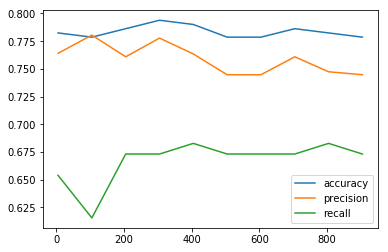

In [444]:
plt.plot(range(5,1001,100), accuracy)
plt.plot(range(5,1001,100), precision)
plt.plot(range(5,1001,100), recall)
plt.legend(['accuracy','precision','recall'])
plt.show()

The best performance seems to be a random forest of approx 200, this gives us a little better performance than bagging.